# Experiment: Million Songs Dataset

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700]
calibration=df.iloc[400000:400500]
test=df.iloc[500000:500300] 

train_y = train[0]
calibration_y = calibration[0]
test_y = test[0] #response:year
train_x = train
calibration_x = calibration
test_x = test
del train_x[0]
del calibration_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
total_x=pd.concat([total_x,calibration_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:1000]
calibration_x=x.iloc[1000:]

train_x.reset_index(drop=True, inplace=True) 
calibration_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
calibration_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 


train_x.shape,calibration_x.shape,test_x.shape

((700, 90), (500, 90), (300, 90))

In [108]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [112]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    dnn_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    dnn_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>500 and float(dnn_trainloss[-1])>max(dnn_trainloss[-500:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {dnn_trainloss[-1]}
            Test  set - loss: {dnn_testloss[-1]}
            ''')
    
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3983575.146122837
            Test  set - loss: 3985007.471276696
            
epoch 100
            Train set - loss: 331.7391438661941
            Test  set - loss: 2756.611956657966
            
epoch 200
            Train set - loss: 112.03384731299111
            Test  set - loss: 1347.2085443268716
            
epoch 300
            Train set - loss: 71.42526242643595
            Test  set - loss: 1089.0420378831525
            
epoch 400
            Train set - loss: 55.87453827285341
            Test  set - loss: 1006.3333005803327
            
epoch 500
            Train set - loss: 48.585486911854574
            Test  set - loss: 971.3660518498718
            
epoch 600
            Train set - loss: 44.36920127302408
            Test  set - loss: 959.0281972

In [113]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2005.468  2001.7762 1993.7863 1984.715  2007.6246 1990.5577 1982.5546
 1991.9896 1940.3383 2093.2458 1999.3068 1996.6295 1992.9501 2129.5396
 1991.7885 1993.4528 1994.9623 2006.4113 1994.3951 2001.3623 1988.3185
 1997.4346 1988.3197 2003.5602 2010.0555 1996.5585 1980.1527 1990.8037
 1987.652  1992.4681 2002.0652 1987.2728 2000.2395 1998.053  1992.8319
 1988.4125 1997.8876 1985.5206 1992.248  1988.2559 2024.6764 1974.1251
 1999.7504 2107.1724 1993.9513 2132.5596 1966.0524 2008.2714 2106.4768
 2065.3423 2005.6166 1957.7588 1996.5958 1996.0521 2028.9945 2024.0809
 2014.3317 2016.1637 1989.2234 2027.6305 2028.8765 2018.0719 2034.4208
 2031.9515 2018.6896 2000.6042 2031.9515 1989.202  2037.4406 1973.1761
 1980.7057 1944.9974 1938.1216 1977.8687 1976.2573 1963.7526 1940.4381
 2112.8008 2007.5963 2182.0996 2106.1235 2030.1389 1970.5717 1983.1368
 1983.586  1974.6498 2046.9991 1993.1318 2005.9686 1974.2473 2057.7783
 2003.5038 1984.713  1995.5594 1990.7413 1990.9298 2007.1814 1992.1066
 1999.

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_trainloss=[]
    t0=time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
        
        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        dnn_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(dnn_trainloss[-1])>max(dnn_trainloss[-200:-1]):
            break
    
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/300
print("95 coverage",dnn_coverage)

confidence interval length [ 67.00256   60.99182   45.463013 105.73218  187.40955   40.641357
  49.288086  60.26367  222.00671  132.18457   47.295288  99.760376
  98.47058  355.99426   76.5459    39.533203 127.91785   37.11438
  28.20105   42.63977  216.18689   65.93042  163.328     47.145508
  40.878784  67.40332   23.32727   34.037354  35.56311   60.11084
  56.902832  47.33789   22.056519  25.358276  31.638916  31.018066
  29.340332  45.236572  49.982178  41.777588 105.631714 149.1908
  81.800415 357.7124   293.4297   400.0465   154.99194  182.0747
 305.37256  281.00854  234.62744  189.51526   91.23901   96.84241
  74.44055  180.68811   95.53381   97.27893  114.309204 197.25256
 200.66138  192.4364   207.84229  203.75916   74.39722   92.829834
 203.75916  127.317505 210.44397   94.66382  133.7533   115.42554
 158.93555   69.823     79.24939   80.24817  365.03394  344.56897
 265.16003  655.33594  284.73877  186.48438  143.53125   67.03088
  68.9541   204.08472  335.02747   64.10181   

## 2. Resnet

In [115]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(90,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    res_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    res_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(res_trainloss[-1])>max(res_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {res_trainloss[-1]}
            Test  set - loss: {res_testloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=90, out_features=32, bias=True)
    (fc2): Linear(in_features=90, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3976256.1381272324
            Test  set - loss: 3979541.61794532
            
epoch 100
            Train set - loss: 516.7128231975223
            Test  set - loss: 5447.853179610818
            
epoch 200
            Train set - loss: 142.23778106440392
            Test  set - loss: 2565.106378117204
            
epoch 300
            Train set - loss: 86.11773866449083
            Test  set - loss: 1985.7226245799163
            
epoch 400
            Train set - loss: 64.01093135386705
            Test  set - loss: 1792.0728960154454
            
epoch 500
            Trai

In [116]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2003.5245 1991.7411 1991.7433 2026.9401 2015.3652 1997.0668 1995.621
 1990.8547 1994.9136 2019.0349 1997.0082 1997.8839 1995.6346 2170.6865
 1990.453  1993.7753 1989.9008 2000.701  1995.7225 2006.1205 2038.5667
 1991.7135 1992.0665 2014.655  2004.4775 1999.327  1978.0841 1988.4402
 1987.8998 1997.1652 1993.3269 1992.8772 2000.9976 1998.2018 1992.6012
 1984.9722 1998.9604 1980.3534 1994.6256 1991.9229 2001.6112 1986.9404
 1975.4274 2092.9463 1971.3497 2129.4321 1976.628  2038.3191 2196.6946
 2061.9333 1968.621  1967.527  2005.3358 2007.048  2023.5892 1997.7837
 1978.0602 2069.309  1979.9515 2080.4744 2080.9043 2074.392  2091.395
 2089.001  2006.5734 2032.0067 2089.001  2059.4182 2093.957  1970.9757
 1968.9606 1948.56   1953.1879 1972.1276 1964.9823 1961.5869 2047.8807
 2051.981  2036.6007 2126.2969 1993.6781 2002.765  1998.3336 1975.1929
 1986.6069 2011.2606 1976.649  2002.2365 2007.4003 1989.4648 2055.8333
 2005.5531 1976.6991 1989.816  1986.0045 1986.7819 2022.6149 1989.692
 1989.598

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=5e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    res_trainloss=[]
    t0=time.time()
    for epoch in range(2000):  
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        res_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(res_trainloss[-1])>max(res_trainloss[-200:-1]):
            break

            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [1:16:25<00:00, 57.32s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
resnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

confidence interval length [ 91.24475   82.83154   62.97766  108.848145 163.98572   48.860596
  68.57422   91.62158  146.61694  112.02893   55.386963 107.578
  75.56201  380.45837   81.66504   48.884644  94.85303   41.63501
  38.731934  43.496094 188.48608   75.74841  118.720215  67.242676
  60.298462  74.36316   36.021484  25.378662  42.623413  58.584473
  67.74158   62.881104  27.970947  33.586304  34.0094    46.95337
  43.57373   51.59497   58.186157  37.975586 116.232666 111.09387
 134.71399  428.6919   284.81836  340.1172   162.17908  179.57434
 287.3108   383.43884  216.92896  148.6305   101.88306   81.632324
  82.28577  155.66199   69.056274 137.0426   124.19299  220.83386
 220.65063  223.29517  222.2843   221.5863    82.84924   85.65674
 221.5863   118.88269  219.82373   98.74072  142.6106   132.35693
 110.49182   59.833984  88.326904 100.46936  346.6443   292.86682
 285.05896  594.76196  261.93677  181.11841  143.61084   70.95911
  70.32837  158.66638  260.6626    60.321777  5

# 3. MLKM

In [35]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [43]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    kernelnn_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(kernelnn_trainloss[-1])>max(kernelnn_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test  set - loss: {kernelnn_testloss[-1]}
            ''')
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3608881.7238394385
            Test  set - loss: 3607754.155064279
            
epoch 100
            Train set - loss: 565.9762030364147
            Test  set - loss: 1932.9195871029794
            
epoch 200
            Train set - loss: 244.61634970826762
            Test  set - loss: 848.7786645394067
            
epoch 300
            Train set - loss: 156.67552111176508
            Test  set - loss: 477.22814619104065
            
epoch 400
            Train set - loss: 128.23723658095514
            Test  set - loss: 334.51877396032216
            
epoch 500
            Train set - loss: 118.16084744287389
            Test  set - loss: 276.9257784817616
            
epoch 600
            Train set - loss: 113.88265260475022
            Test  set - loss: 252.5842611996333
            
epoch 700
            Train se

In [44]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[1998.1606 1990.2922 2007.3636 1996.4951 1991.2303 2000.7621 2000.8914
 1993.8359 1997.4735 1993.5367 1996.5055 1988.0569 2006.5928 1995.0981
 1978.0044 1989.5648 2011.8094 1988.995  1992.9053 2004.111  2011.468
 1986.8718 2012.5063 1995.8577 2006.8542 1976.0901 2003.1411 2005.4128
 2001.6796 1985.707  1984.3778 1978.1036 2005.9913 1997.3118 2000.1755
 1982.6062 1989.6309 1988.7905 1993.5975 1987.1353 2001.4567 2002.7363
 2001.3577 2005.3776 1997.6821 1995.2758 1986.9873 1991.2    1999.3745
 2004.0336 1995.4275 1994.4088 1998.6132 1990.1724 1999.2977 1979.2882
 1998.885  1997.1622 1991.7404 1983.6439 1989.8473 2000.4636 2003.4785
 2002.5631 1988.6332 1992.4537 2002.5631 2000.1422 1979.9275 1997.6808
 1996.8027 1992.5004 1988.6499 1996.2144 2003.9454 2009.4163 2004.7738
 1991.0035 1993.9299 1990.681  1991.628  1989.0602 2005.151  2003.556
 1991.072  1977.0472 2001.302  2002.5868 1989.672  1992.9279 1992.7051
 1995.0817 2008.6808 1994.0721 1993.0687 1996.8398 1993.4324 2002.255
 1986.484

In [45]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-calibration_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(calibration_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 500/500 [00:00<00:00, 1217.66it/s]


476.0


100%|██████████| 300/300 [00:00<00:00, 1417.54it/s]

length 52.547820536295575
95 coverage 0.9062111111111112


In [46]:
##conformal prediction
#predict
x0=torch.from_numpy(calibration_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-calibration_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(calibration_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
for i in range(len(test_x)):
    if pred.detach().numpy()[i][0]-a<test_y[i] and pred.detach().numpy()[i][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)



476.0
length tensor(47.6404, dtype=torch.float64)
95 coverage 0.8633333333333333


In [30]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9) #optim.Adam(...)
    kernelnn_trainloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(kernelnn_trainloss[-1])>max(kernelnn_trainloss[-200:-1]):
            break
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [42:16<00:00, 31.70s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
kernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/300
print("95 coverage",kernelnet_coverage)

confidence interval length [48.813843 44.495483 47.101807 52.012817 42.59839  47.36914  47.07251
 46.513916 49.718872 51.67859  43.577637 52.006958 39.97827  59.37976
 52.291138 49.14453  49.558716 40.291504 42.658203 45.173462 46.866333
 42.46106  44.28357  46.630737 47.87146  50.593384 45.09314  48.735718
 47.618042 49.24951  43.50952  52.478027 45.619873 39.45398  47.436768
 59.575317 43.645752 48.744995 44.072998 44.53308  50.95581  49.062134
 44.250977 44.828125 51.98401  49.43811  42.286255 48.28882  44.4021
 47.393677 49.99402  44.107056 49.788574 42.785645 41.028442 42.04187
 43.801514 48.588135 44.399048 44.25232  43.431763 36.768555 46.00476
 49.297974 41.859863 37.477783 49.297974 50.041626 49.89563  50.316406
 47.897583 45.935303 44.420776 39.35559  44.42041  47.845337 49.837524
 46.693237 47.59839  46.834473 43.966553 51.128906 47.923584 47.699585
 44.347168 52.289185 49.751953 40.016846 44.190796 44.637207 39.818604
 49.547485 48.506958 55.031982 45.931152 47.410645 50.53

# 4. RKM

In [47]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    reskernel_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(reskernel_trainloss[-1])>max(reskernel_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            Test  set - loss: {reskernel_testloss[-1]}
            ''')
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3983873.1850934085
            Test  set - loss: 3984843.151937588
            
epoch 100
            Train set - loss: 173.90573396995663
            Test  set - loss: 208.11205218111476
            
epoch 200
            Train set - loss: 147.44808355842318
            Test  set - loss: 201.59749802847702
            
epoch 300
            Train set - loss: 137.68064719364048
            Test  set - loss: 195.90419554367662
            
epoch 400
            Train set - loss: 132.39460991237846
            Test  set - loss: 192.5602679497997
            
epoch 500
            Train set - loss: 128.99141064650246
            Test  set - loss: 190.1235961601635
            
epoch 600
            Train set - loss: 126.46986413

In [48]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[1996.1675 1998.9708 1994.6748 2004.0049 1995.6462 1995.403  1992.3832
 1996.001  2002.1898 2007.153  1999.1521 1994.0646 2002.9443 2001.0236
 2003.3064 1996.965  2009.5116 2000.0382 1993.9823 1992.1257 2003.1775
 1996.0905 2008.9147 2001.2706 2003.582  2006.5397 1991.6234 1988.6444
 1989.5713 1994.1472 1999.1486 1991.6725 1997.6316 1996.446  1987.2405
 1994.6709 1998.7693 1984.0739 1996.5961 1985.0651 1999.6791 1997.78
 1983.035  2006.6294 2002.7026 2001.0759 1998.7826 1995.8698 2008.2224
 1996.508  2001.4125 1991.7278 2005.7614 2005.5454 2005.6289 1995.4058
 2003.4828 1991.981  2005.2003 2003.4816 2003.5278 2001.9677 2002.0688
 2001.8516 1997.319  2000.2275 2001.8516 2000.3252 2003.4977 2000.4344
 2001.0559 2005.3868 1998.8442 1995.273  1990.5369 1999.963  1984.9127
 1989.483  1996.8763 2004.099  2003.182  1997.9988 1996.2991 1994.2103
 1989.8469 1990.5211 1998.2205 1990.1572 1990.3267 1992.3291 2001.8009
 1989.0432 1989.511  1996.3606 1990.2139 2002.9271 2006.2823 1994.9746
 1994.43

In [26]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1076.56it/s]


torch.Size([700, 345])
1022.7783203125


100%|██████████| 300/300 [00:00<00:00, 928.82it/s]

n-p: 355  mark: 195
length 39.22746728118528
95 coverage 0.8256410256410256


In [50]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-calibration_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(calibration_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 500/500 [00:00<00:00, 1007.05it/s]


476.0


100%|██████████| 300/300 [00:00<00:00, 1110.29it/s]

length 41.14805526097616
95 coverage 0.8328777777777778


In [51]:
##conformal prediction
#predict
x0=torch.from_numpy(calibration_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-calibration_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(calibration_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
x0=torch.from_numpy(test_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
for i in range(len(test_x)):
    if pred.detach().numpy()[i][0]-a<test_y[i] and pred.detach().numpy()[i][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)


476.0
length tensor(35.2053, dtype=torch.float64)
95 coverage 0.82


In [36]:
#bootstrap  
boottime=200

for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9) #optim.Adam(...)
    reskernel_trainloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(reskernel_trainloss[-1])>max(reskernel_trainloss[-200:-1]):
            break
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 200/200 [22:22<00:00,  6.71s/it]


In [35]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,195]-bootbase)
upper=bootbase-(sorted_bootlist[:,5]-bootbase)
print("confidence interval length",sorted_bootlist[:,195]-sorted_bootlist[:,5])
reskernelnet_length=(sorted_bootlist[:,195]-sorted_bootlist[:,5]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

confidence interval length [ 17.40149    16.201294   16.162842   22.511475   17.604004   15.6427
  23.461426   16.033203   20.377563   21.12854    19.125854   14.720337
  19.84375    23.317017   21.560669   14.105103   12.104248   14.793335
  25.848999   15.000244   26.46936    19.019775   17.262451   17.774902
  16.136108   18.916138   14.684937   17.369385   12.564087   17.822144
  18.401978   14.753784   12.348755   12.488403   20.485718   13.786499
  12.845093   16.651855   13.303101   16.901001   17.746216   14.081055
  20.084595   30.704468   22.069824   34.573975   22.288696   21.393677
  89.06775    48.000244   24.49414    19.704712   16.458374   18.574463
  39.60193    14.103394   31.233643   15.417847   33.72583    19.80371
  19.831665   20.704834   20.369507   19.592896   17.811646   18.411499
  19.592896   21.056152   20.72583    14.246216   23.423218   14.851685
  23.280151   15.55127    23.644165   17.677734   31.621948   41.1792
  21.019897  167.03357    14.717773   14.1

comparison

In [61]:
def plot_choose(fig,start,data,linestyle="-"):
    fig.plot(np.arange(start,len(data)),data[start:],linestyle=linestyle)

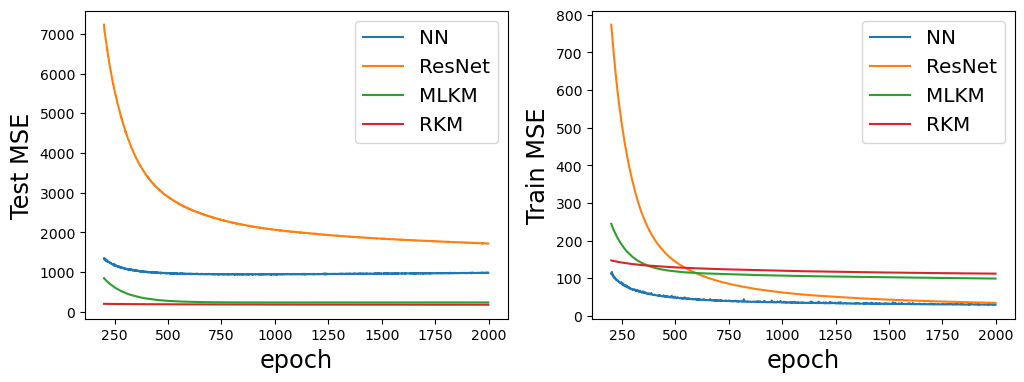

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,dnn_testloss)
plot_choose(ax[0],200,res_testloss)
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,dnn_trainloss)
plot_choose(ax[1],200,res_trainloss)
plot_choose(ax[1],200,kernelnn_trainloss)
plot_choose(ax[1],200,reskernel_trainloss)
ax[1].legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

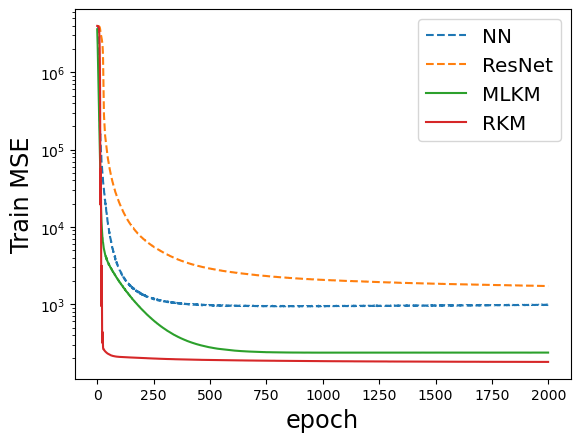

In [64]:
plt.plot(dnn_testloss,linestyle='dashed')
plt.plot(res_testloss,linestyle='dashed')
plt.plot(kernelnn_testloss)
plt.plot(reskernel_testloss)
plt.legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.ylabel("Train MSE",fontsize="xx-large")
plt.yscale('log')
plt.show()

## 3+. multi-layer learning (data splitting) 

In [99]:
#multi
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters()}],lr=7e-4,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=7e-4,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
alltrainloss=[[],[]]
alltestloss=[[],[]]
splkernel_trainloss=[]
splkernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                alltrainloss[i].append(float(train_loss[i]))
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
    
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x0 = x0.to(device)
            pred = netset[i](x0)
            train_loss[i] = mean_squared_error(train_y,pred)
            alltrainloss[i].append(float(train_loss[i]))
            
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x1 = x1.to(device)
            pred = netset[i](x1)
            test_loss[i] = mean_squared_error(test_y,pred)
            alltestloss[i].append(float(test_loss[i]))
    
    if epoch>200 and float(sum(train_loss)/len(train_loss))>max(splkernel_trainloss[-200:-1]):
        break      
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splkernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splkernel_testloss.append(float(sum(test_loss)/len(test_loss)))
    
        
dnn_fit = time.time() - t0
print("KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3747074.2099942667
            Test  set - loss: 3748216.1373255737
            
epoch 100
            Train set - loss: 1594.3947568531867
            Test  set - loss: 2232.8873379358897
            
epoch 200
            Train set - loss: 456.2880174265696
            Test  set - loss: 724.4117228163034
            
epoch 300
            Train set - loss: 205.46635546421368
            Test  set - loss: 319.76325710433224
            
epoch 400
            Train set - loss: 146.81127924515732
            Test  set - loss: 212.65007041804492
            
epoch 500
            Train set - loss: 134.63320747330783
            Test  set - loss: 183.7370159010589
            
epoch 600
            Train set - loss: 133.3489213495276
            Test  set - loss: 175.66073672384022
            
epoch 700
            Train set - loss: 134.04246790229212
            Test  set - loss: 173.38187161338828
            
KernelNet(data splitting) complexity a

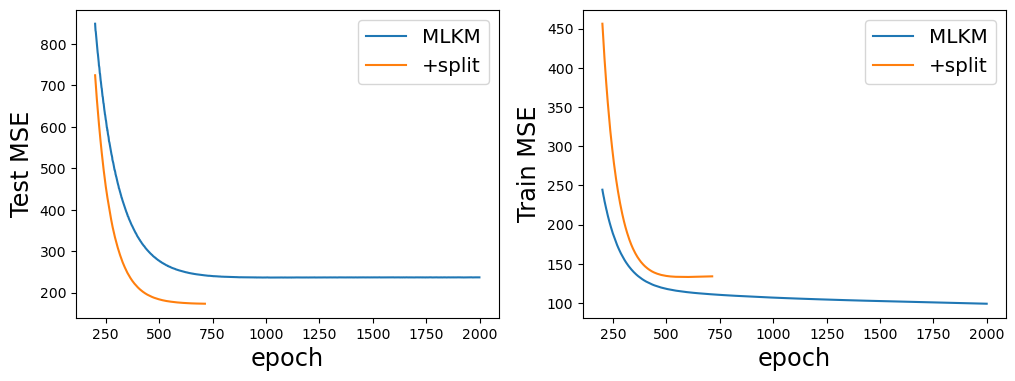

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,splkernel_testloss)
ax[0].legend(["MLKM","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,kernelnn_trainloss)
plot_choose(ax[1],200,splkernel_trainloss)
ax[1].legend(["MLKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

## 4+. residual learning (data splitting) 

In [93]:
#res
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
alltrainloss=[[],[],[]]
alltestloss=[[],[],[]]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.rblock1.parameters()}],lr=1e-6,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=1e-6,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                alltrainloss[i].append(float(train_loss[i]))
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x0 = x0.to(device)
            pred = netset[i](x0)
            train_loss[i] = mean_squared_error(train_y,pred)
            alltrainloss[i].append(float(train_loss[i]))
            
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x1 = x1.to(device)
            pred = netset[i](x1)
            test_loss[i] = mean_squared_error(test_y,pred)
            alltestloss[i].append(float(test_loss[i]))
    
    if epoch>200 and float(sum(train_loss)/len(train_loss))>max(splreskernel_trainloss[-200:-1]):
        break      
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("ResKernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 4000827.679639168
            Test  set - loss: 4001627.2650266904
            
epoch 100
            Train set - loss: 261.1428014393257
            Test  set - loss: 290.93942790190374
            
epoch 200
            Train set - loss: 207.02045872969288
            Test  set - loss: 253.10090289644899
            
epoch 300
            Train set - loss: 185.31975999533066
            Test  set - loss: 238.39005907987553
            
epoch 400
            Train set - loss: 172.13207959767962
            Test  set - loss: 229.27594896751145
            
epoch 500
            Train set - loss: 163.1008564903587
            Test  set - loss: 223.21856133038798
            
epoch 600
            Train set - loss: 156.44584392350697
            Test  set - loss: 218.9582064820081
            
epoch 700
            Train set - loss: 151.54969608823103
            Test  set - loss: 215.88159423450628
            
epoch 800
            Train set - loss

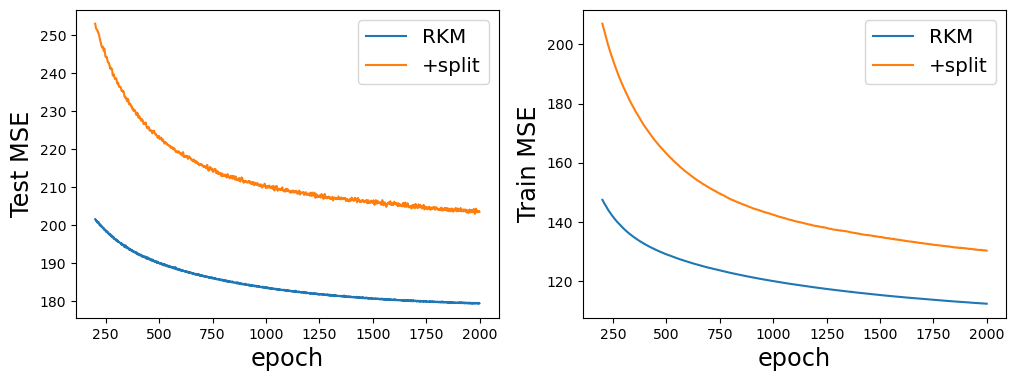

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,reskernel_testloss)
plot_choose(ax[0],200,splreskernel_testloss)
ax[0].legend(["RKM","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,reskernel_trainloss)
plot_choose(ax[1],200,splreskernel_trainloss)
ax[1].legend(["RKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

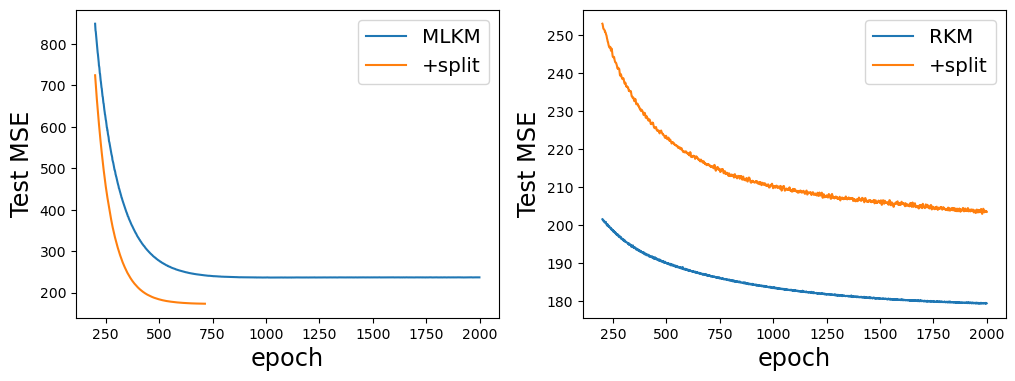

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,splkernel_testloss)
ax[0].legend(["MLKM","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,reskernel_testloss)
plot_choose(ax[1],200,splreskernel_testloss)
ax[1].legend(["RKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Test MSE",fontsize="xx-large")
plt.show()

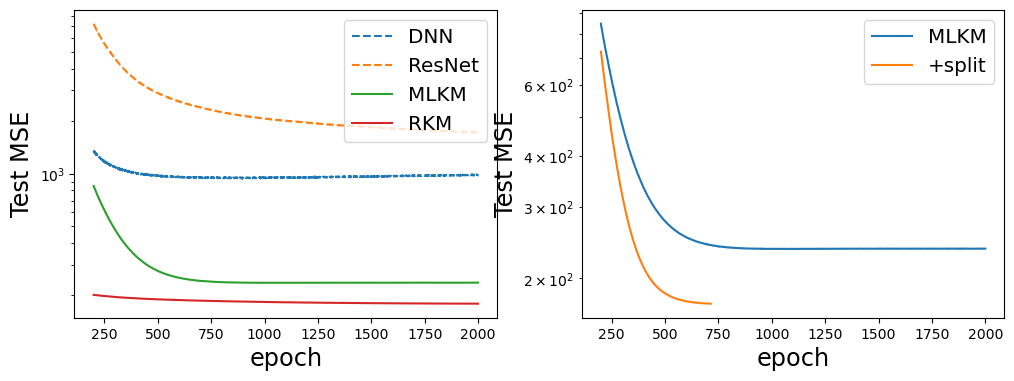

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,dnn_testloss,linestyle="--")
plot_choose(ax[0],200,res_testloss,linestyle="--")
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["DNN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")
ax[0].set_yscale('log')

plot_choose(ax[1],200,kernelnn_testloss)
plot_choose(ax[1],200,splkernel_testloss)
ax[1].legend(["MLKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Test MSE",fontsize="xx-large")
ax[1].set_yscale('log')
plt.show()

In [119]:
print(dnn_trainloss[-1],res_trainloss[-1],kernelnn_trainloss[-1],reskernel_trainloss[-1],splkernel_trainloss[-1],splreskernel_trainloss[-1])
print(dnn_testloss[-1],res_testloss[-1],kernelnn_testloss[-1],reskernel_testloss[-1],splkernel_testloss[-1],splreskernel_testloss[-1])

29.8582748069082 23.881899700888564 99.2315137720108 112.29510683157615 134.13664416338716 130.24539075070194
980.8735665245354 1486.2006560148795 236.84973162894448 179.4738853656749 173.25557762439053 203.5771660279234
